<a href="https://colab.research.google.com/github/polina-minaeva/ssa-singular-spectral-analysis/blob/main/5_%D0%A1%D0%B8%D0%BD%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D0%B5%D0%BA%D1%82%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Возьмем временной ряд о перевозках пассажиров и проведем сингулярный спектральный анализ (SSA)

1. Загружаем данные

In [ ]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [ ]:
passengers = pd.read_csv('international-airline-passengers.csv')['Count'] #загружаем данные и фиксируем временной ряд

passengers

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: Count, Length: 144, dtype: int64

In [ ]:
N = passengers.count()
N

144

2. Строим матрицу траекторий, превращаем временной ряд в матрицу

In [ ]:
L = 72
K = N - L + 1 #число столбцов в матрице траекторий

X = np.column_stack([passengers[i:i+L] for i in range(0,K)])

Text(0.5, 1.0, 'The Trajectory Matrix for Time Series')

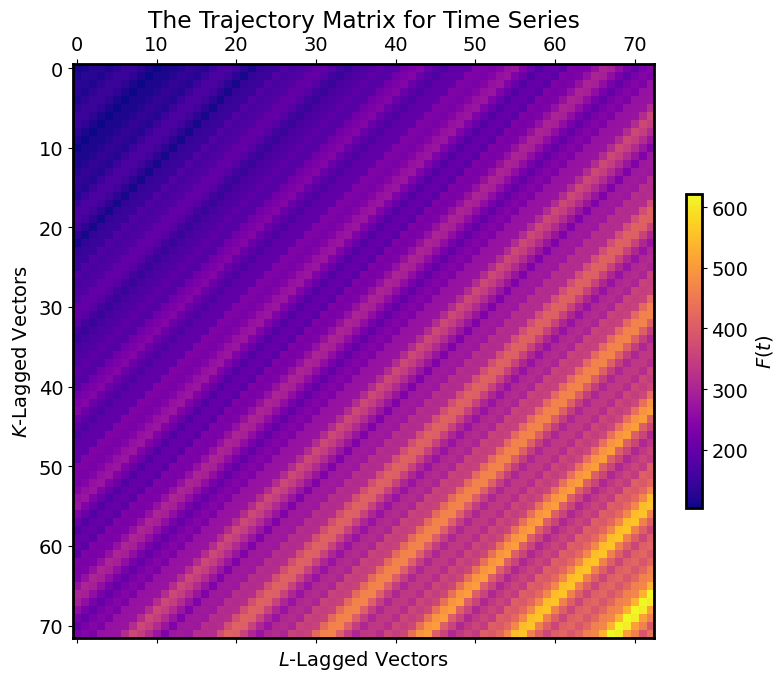

In [ ]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.025)
ax.colorbar.set_label("$F(t)$")
plt.title("The Trajectory Matrix for Time Series")

3. Делим матрицу на элементарные

In [ ]:
d = np.linalg.matrix_rank(X)

U, Sigma, V = np.linalg.svd(X)
V = V.T

X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

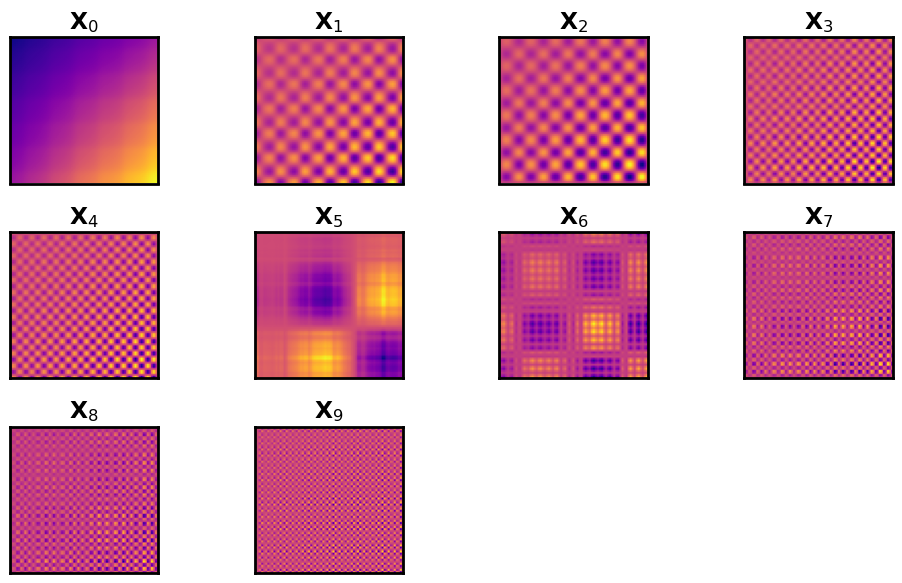

In [ ]:
n = min(10, d)
for i in range(n):
    plt.subplot(4,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

Как видим, некоторые матрицы между собой похожи. Х0 можно отделить от остальных, а остальные сгруппировать Х1 и Х2; Х3 и Х4; Х5 и Х6; Х7, Х8, Х9

4. Посмотрим вклад каждой элементарной матрицы в матрице траекторий

Text(0, 0.5, 'Contribution (%)')

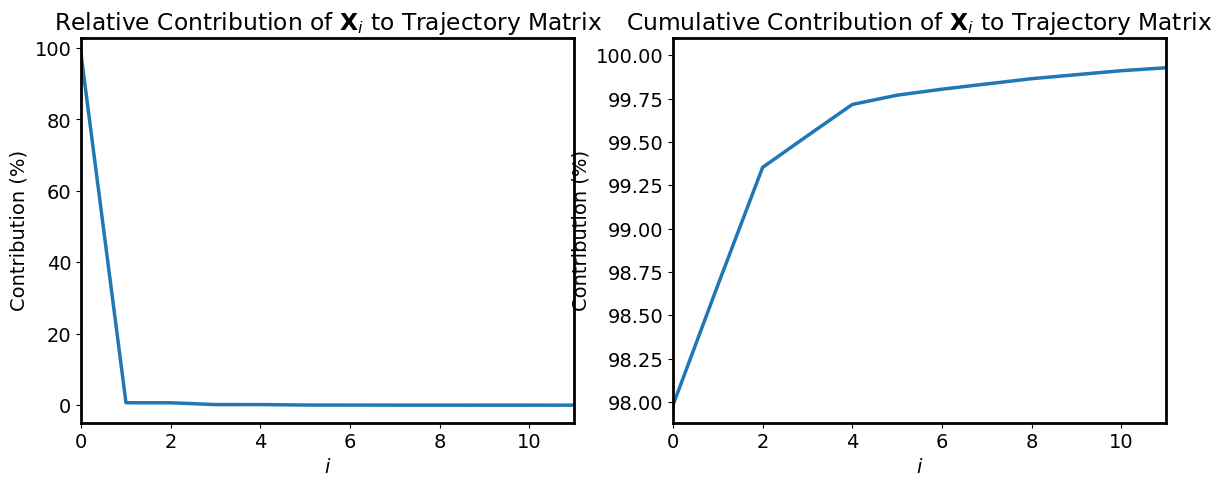

In [ ]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)")

Наибольшой вклад вносит Х0 – 98%. Далее важны – Х1, Х2, Х3, Х4. После этого кумулятивный вклад выходит на плато.

5. Ханкелизация матриц

In [ ]:
def Hankelise(X):
    L, K = X.shape
    transpose = False
    if L > K:
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))

    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

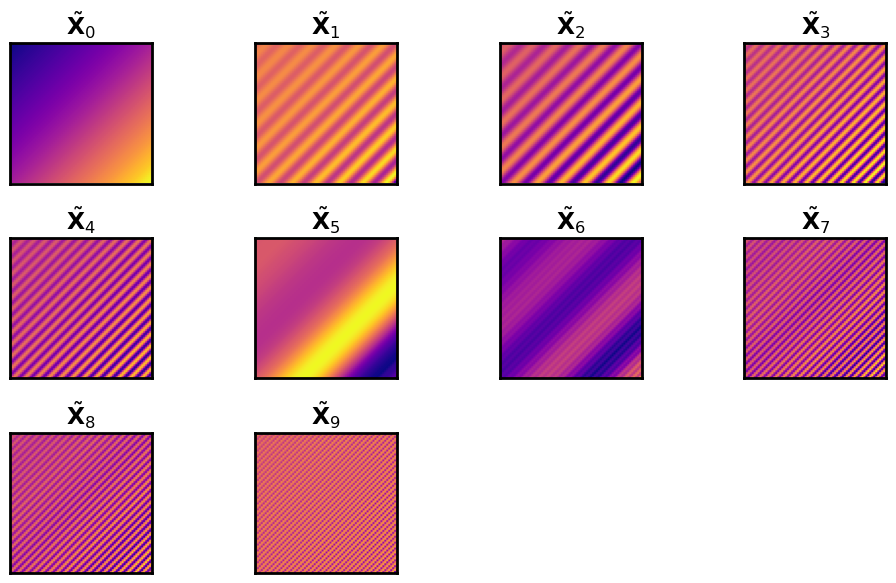

In [ ]:
n = min(d, 10)
for j in range(0,n):
    plt.subplot(4,4,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout()

После первого разложения матрицы на элементарные мы определились, что выделяются такие группы: Х0; Х1 и Х2; Х3 и Х4; Х5 и Х6; Х7, Х8 и Х9.

В целом, это разделение соотвествует тому разделению, которое мы наблюдаем при ханкелизации матриц сейчас.

6. Построим игрушечный временной ряд

In [ ]:
def X_to_TS(X_i):
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

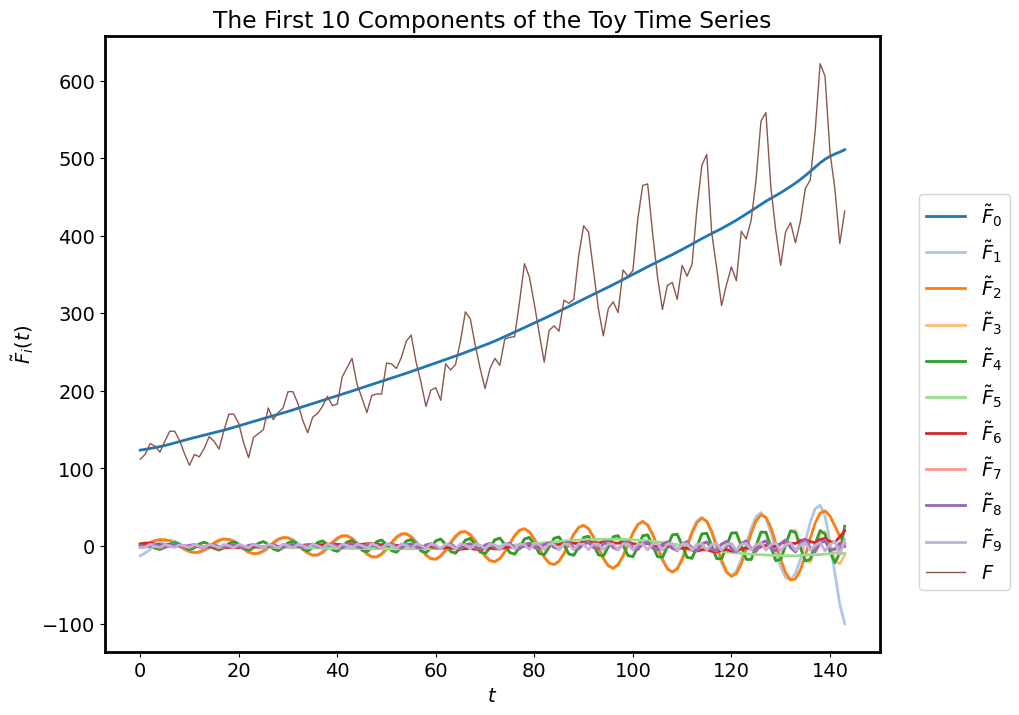

In [ ]:
#далее строим игрушечный временной ряд, чтобы на графике отобразить его важные элементы

t = np.arange(0,N)

fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, passengers, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 10 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1))

На графике явно можно различить F0, F1, F2, F4

7. Группировка элементов временного ряда

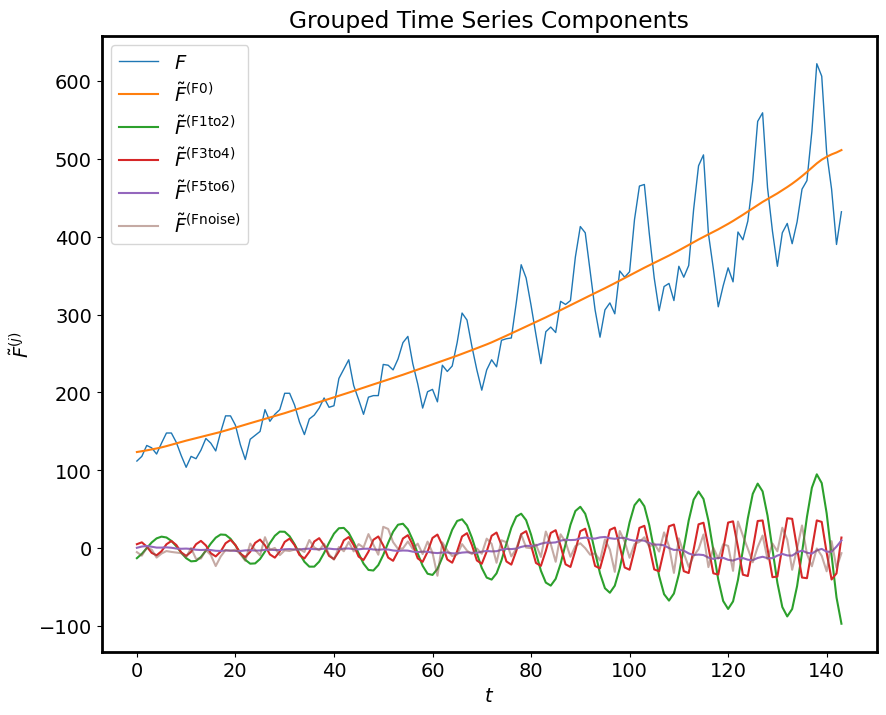

In [ ]:
#попробуем сгруппировать ранее обозначенные нами группы

F0 = X_to_TS(X_elem[0])
F1to2 = X_to_TS(X_elem[[1,2]].sum(axis=0))
F3to4 = X_to_TS(X_elem[[3,4]].sum(axis=0))
F5to6 = X_to_TS(X_elem[[5,6]].sum(axis=0))
Fnoise = X_to_TS(X_elem[7:].sum(axis=0))


plt.plot(t, passengers, lw=1)
plt.plot(t, F0)
plt.plot(t, F1to2)
plt.plot(t, F3to4)
plt.plot(t, F5to6)
plt.plot(t, Fnoise, alpha=0.5)

plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["F0", "F1to2", "F3to4", "F5to6", "Fnoise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

По графику видим, что F0 похоже на тренд, F1to2 на сезонность, F3to4 тоже на сезонность, F5to6 похоже и на тренд и на сезонность. Fnoise – это шум.

8. Матрица корреляций

In [ ]:
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

Text(0.5, 1.0, 'The W-Correlation Matrix for the Toy Time Series')

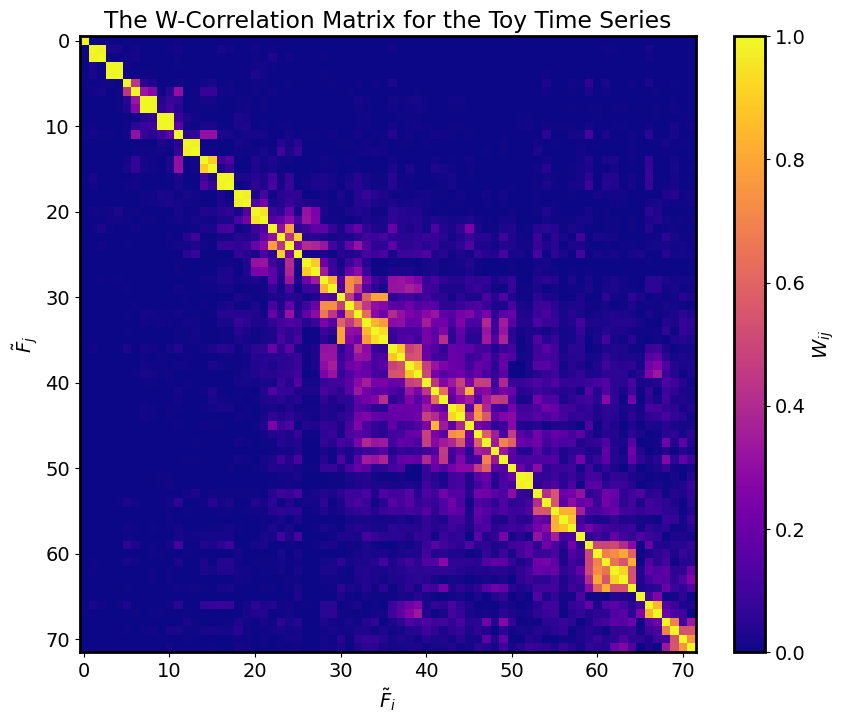

In [ ]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Toy Time Series")

Значительная корреляция начинает проявляться на уровне F5–F6. То, что идет далее, можно отнести к белому шуму.

Text(0.5, 1.0, 'W-Correlation for Components 0–6')

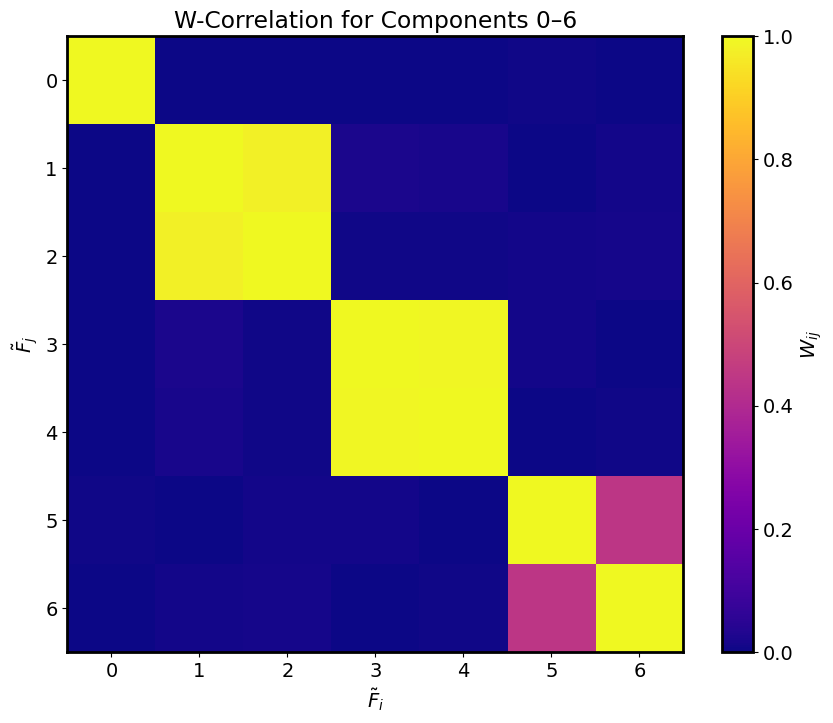

In [ ]:
#рассмотрим ближе элементы до F6

ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,6.5)
plt.ylim(6.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–6")

Итак, большую корреляцию имеют F1 И F2, F3 и F4, F5 и F6. Их мы и сгруппировали ранее.

Теперь попробуем поэкспериментировать и применить к данным разную длину окна

In [ ]:
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):

        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):

        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):


        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):

        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

Начнем с длины 3

Text(0.5, 1.0, '$L=3$ for the Toy Time Series')

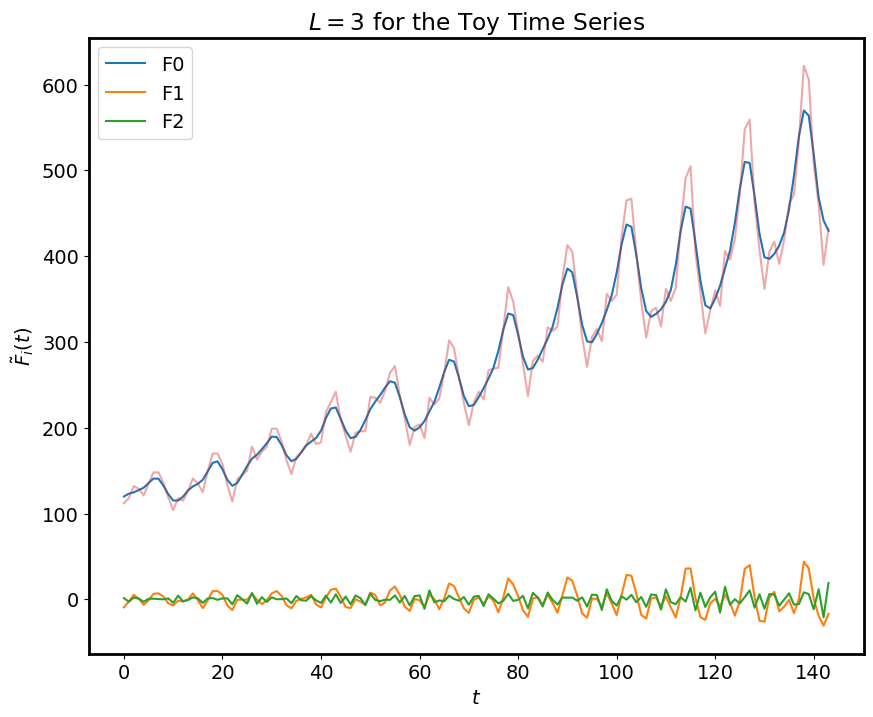

In [ ]:
F_ssa_L3 = SSA(passengers, 3)
F_ssa_L3.components_to_df().plot()
F_ssa_L3.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=3$ for the Toy Time Series")

По графику видно, что при L=3 – слишком мало элементов. Кроме того, F1 и F2 наслаиваются дру на друга. Попробуем увелиичить длину окна до 19

Text(0.5, 1.0, '$L=19$ for the Toy Time Series')

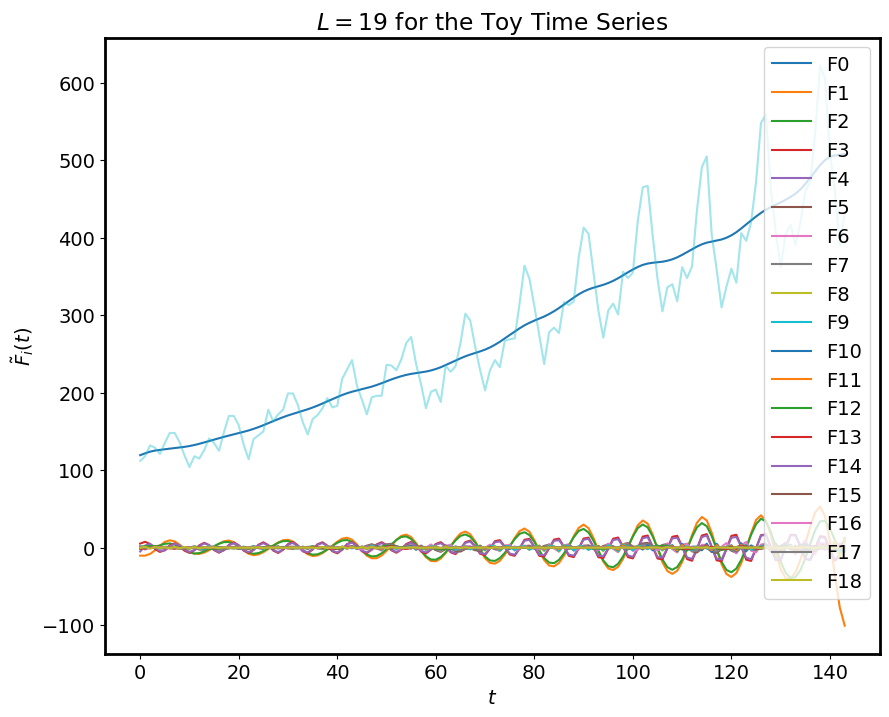

In [ ]:
F_ssa_L19 = SSA(passengers, 19)
F_ssa_L19.components_to_df().plot()
F_ssa_L19.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=19$ for the Toy Time Series")

Мы видим, что внизу графику лучше отделились друг от друга элементы, выделились три "узора". Пробуем увеличить длину окна еще больше, до 50

Text(0.5, 1.0, '$L=50$ for the Toy Time Series')

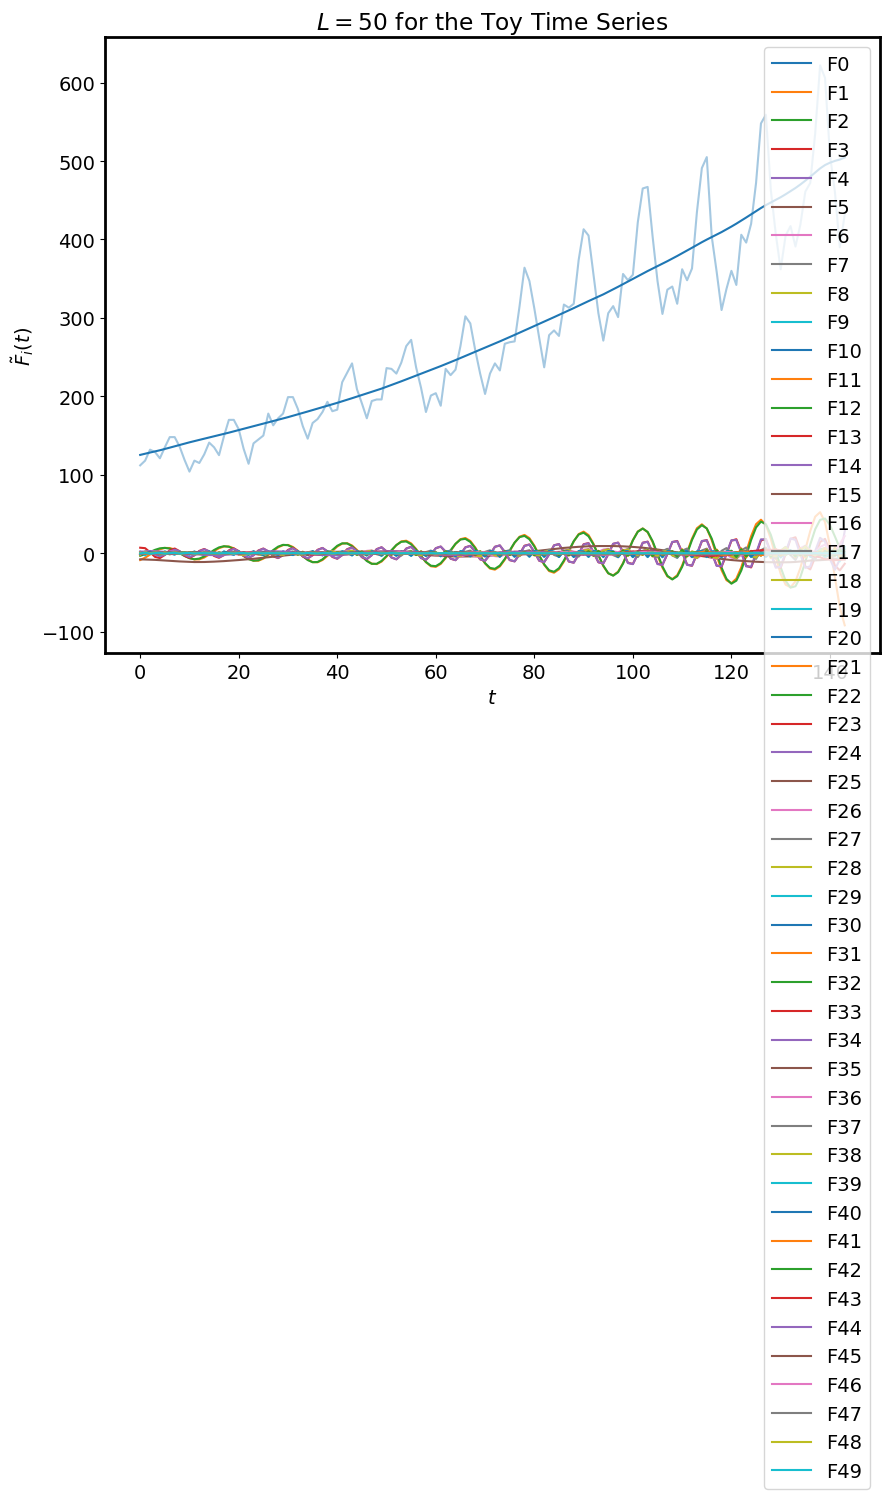

In [ ]:
F_ssa_L50 = SSA(passengers, 50)
F_ssa_L50.components_to_df().plot()
F_ssa_L50.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=50$ for the Toy Time Series")

Появилось еще больше элементов, и они наслаиваются внизу на три отмеченных нами "узора".

Text(0.5, 1.0, 'W-Correlation for Toy Time Series, $L=50$')

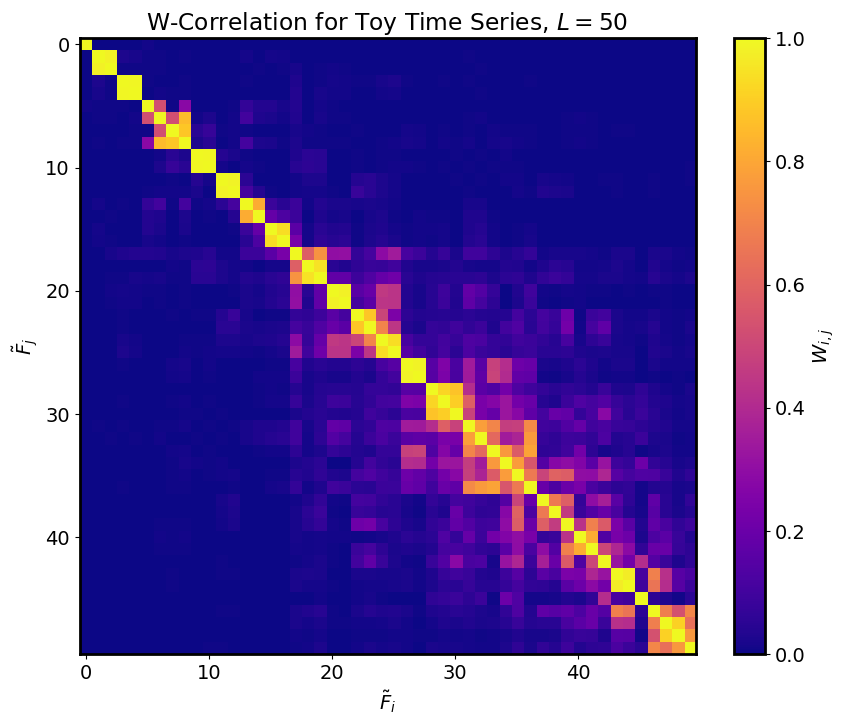

In [ ]:
F_ssa_L50 = SSA(passengers, 50)
F_ssa_L50.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=50$")

На матрице корреляций можно провести линию на уровне F5–F6 и отделить белый шум.

А теперь сделаем график с длиной 72, какую мы применяли при анализе

Text(0.5, 1.0, '$L=72$ for the Toy Time Series')

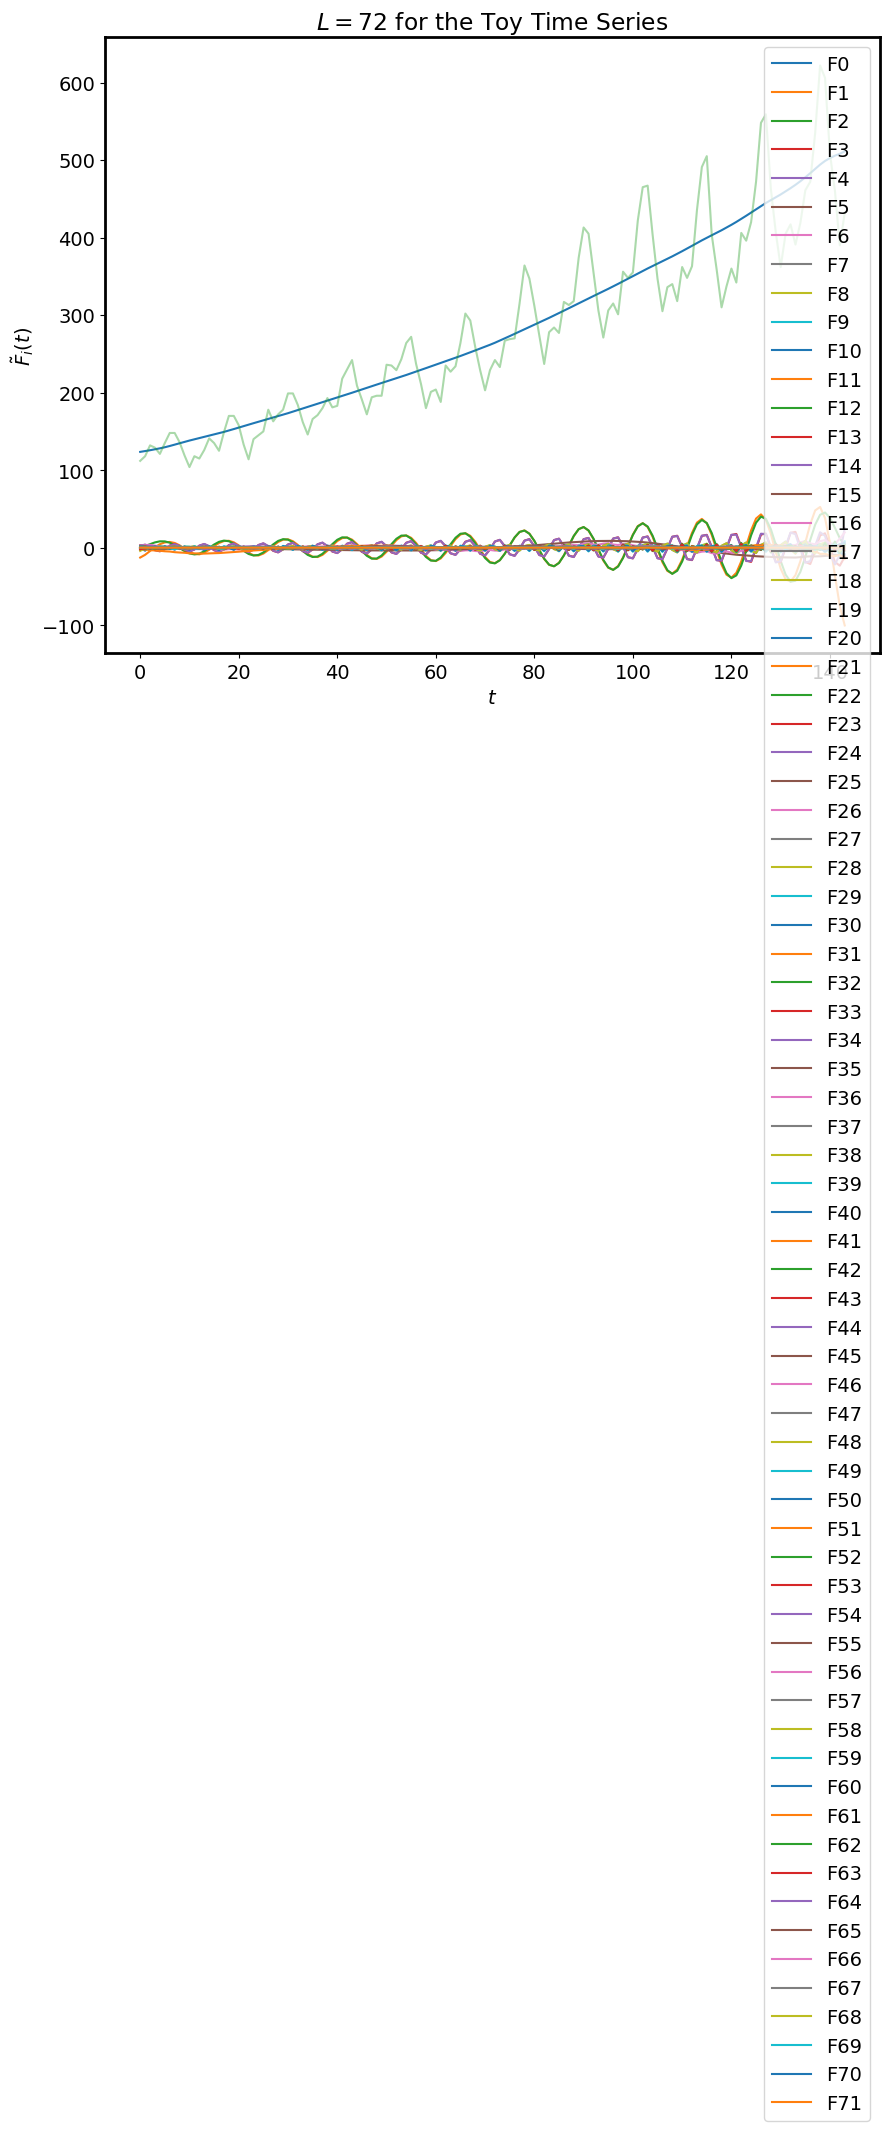

In [ ]:
F_ssa_L72 = SSA(passengers, 72)
F_ssa_L72.components_to_df().plot()
F_ssa_L72.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=72$ for the Toy Time Series")

Text(0.5, 1.0, 'W-Correlation for Toy Time Series, $L=72$')

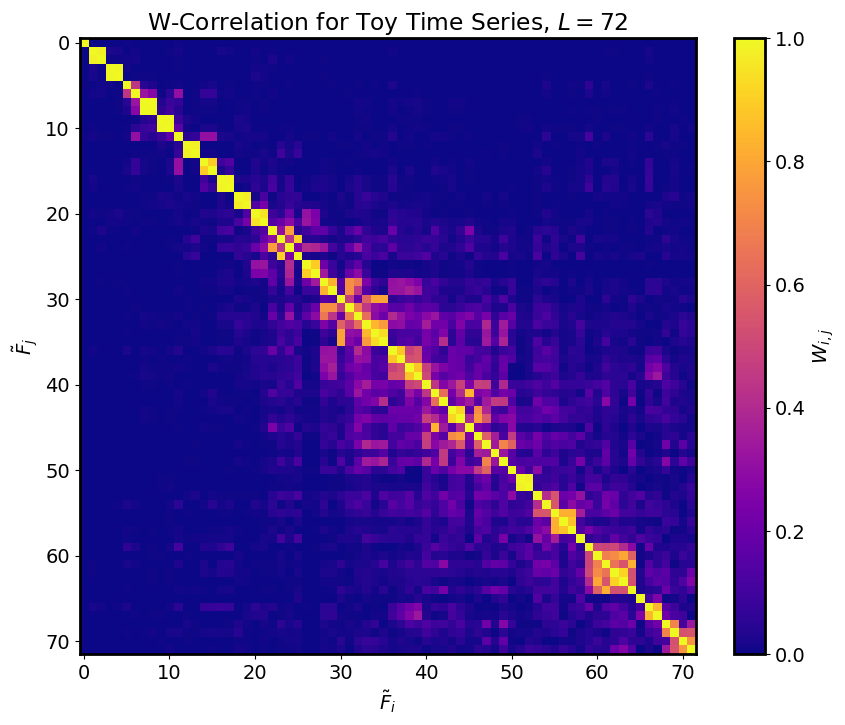

In [ ]:
#и посмотрим на матрицу корреляций

F_ssa_L72 = SSA(passengers, 72)
F_ssa_L72.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=72$")

При длине 72 мы также видим белый шум после F6 и корреляцию элементов до F6. Именно они и являются важными во временном ряде.